# Analyse de données des requêtes
Première requête : 2022-10-14

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pour l'analyse unidimensionnelle et multidimensionnelle : 
from math import sqrt, log
from pandas.plotting import scatter_matrix
from pyensae.graphhelper import Corrplot

# pour la Factor-Analysis-of-Mixed-Data (FAMD) : 
from light_famd import FAMD
from sklearn.preprocessing import scale

#clustering
#from sklearn.cluster import KMeans
#from sklearn.cluster import AgglomerativeClustering
#from scipy.cluster.hierarchy import dendrogram

# Chargement des données 

In [61]:
PATH = '../requetes/'
'''
files_name = ['result' + str(i) + '.csv' for i in range(1,13)]
data = pd.DataFrame()

# résultats des requêtes : 
for file in files_name : 
    data = pd.concat([data,pd.read_csv(PATH+file)],ignore_index=True)
data.to_csv(PATH+'requetes1.csv',index=False)
'''
#plus besoin de concaténer les fichiers maintenant, juste load le 
# fichier que j'ai enregistré : 
data = pd.read_csv(PATH+'requetes1.csv')
data.head()

,avatar_id,city,date,language,mobile,hotel_id,price,stock
0,3530,paris,40,dutch,0,467,244,214
1,3530,paris,40,dutch,0,708,147,102
2,3530,paris,40,dutch,0,853,147,110
3,3530,paris,40,dutch,0,207,154,108
4,3530,paris,40,dutch,0,415,116,83


In [62]:
# ajouter les features des hôtels : 
features_hotels = pd.read_csv(PATH+'features_hotels.csv')

# take hotels in the order in which they are found in the request dataset and concatenate the two dataframes
hotels_in_order = features_hotels.loc[data['hotel_id']]

# check that the city between the two dataframes are matching : 
cities_in_order = np.array(hotels_in_order['hotel_id'])
cities_request = np.array(data['hotel_id'])
diff_cities = len(np.where(cities_in_order!=cities_request)[0])

# if cities are the same we can delete one of the columns :
if diff_cities == 0 : 
    hotels_in_order.drop('city',axis=1,inplace=True)    
print("nombre de requetes pour lesquelles la ville de l'hotel ne matche pas avec la ville demandée : ",diff_cities)

# finally we concatenate the two dataframes:
hotels_in_order.drop('hotel_id',axis=1,inplace=True)
hotels_in_order.reset_index(inplace=True)
data = pd.concat([data,hotels_in_order],axis=1)
data.drop('index',axis=1,inplace=True)
data.to_csv(PATH+'requetes1.csv',index=False)
data.head()

nombre de requetes pour lesquelles la ville de l'hotel ne matche pas avec la ville demandée :  0


,avatar_id,city,date,language,mobile,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,3530,paris,40,dutch,0,467,244,214,Accar Hotels,Safitel,0,0,0
1,3530,paris,40,dutch,0,708,147,102,Yin Yang,Ardisson,1,0,0
2,3530,paris,40,dutch,0,853,147,110,Chillton Worldwide,Tripletree,1,0,0
3,3530,paris,40,dutch,0,207,154,108,Boss Western,J.Halliday Inn,0,0,1
4,3530,paris,40,dutch,0,415,116,83,Boss Western,Boss Western,1,0,0


In [63]:
# définition des variables quntitatives et qualitatives : 
var_quant = ["date","price","stock"]
var_quali = ["avatar_id","city","language", "mobile", "hotel_id","group","brand","parking","pool","children_policy"]

In [64]:
# Transform the dataset with the correct types : 
for var in var_quali :
    data[var]=pd.Categorical(data[var],ordered=False)

data.dtypes

avatar_id          category
city               category
date                  int64
language           category
mobile             category
hotel_id           category
price                 int64
stock                 int64
group              category
brand              category
parking            category
pool               category
children_policy    category
dtype: object

In [65]:
data.describe()

,date,price,stock
count,107046.000000,107046.000000,107046.000000
mean,21.350989,155.922930,42.702988
std,12.726681,77.354132,50.535012
min,0.000000,38.000000,0.000000
25%,10.000000,97.000000,6.000000
50%,21.000000,141.000000,24.000000
75%,32.000000,191.000000,62.000000
max,43.000000,529.000000,269.000000


# Exploration unidimensionnelle

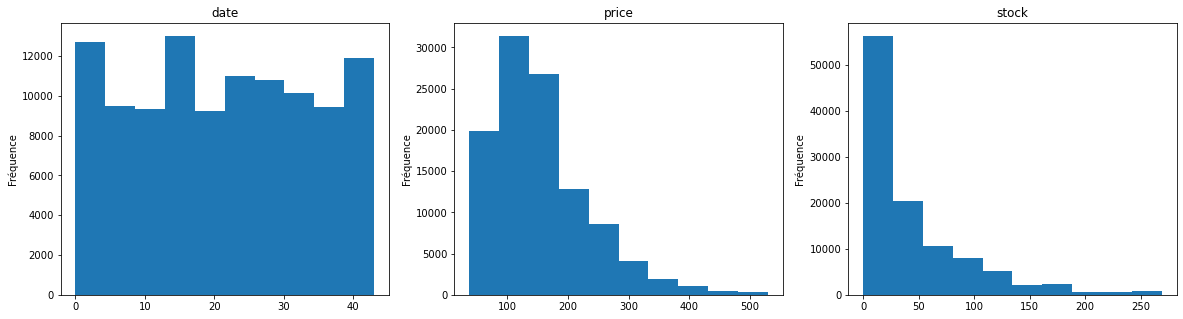

In [66]:
fig = plt.figure(figsize=(20, 5))

for i in range(0,len(var_quant)):
    plt.subplot(1, 3, i+1)
    plt.hist(data[var_quant[i]])
    plt.title(var_quant[i])
    plt.ylabel('Fréquence')
plt.show()
plt.close()

Commentaires : 
- price et stock suivent une distribution exponentielle => on va donc pouvoir leur appliquer une transformation **log** pour les recentrer. Le problème c'est que stock a une masse en zero, donc on va plutôt lui appliquer du sqrt.
- date a une répartition assez uniforme de 0 à 44 => bon point pour la manière donc on a fait les requêtes

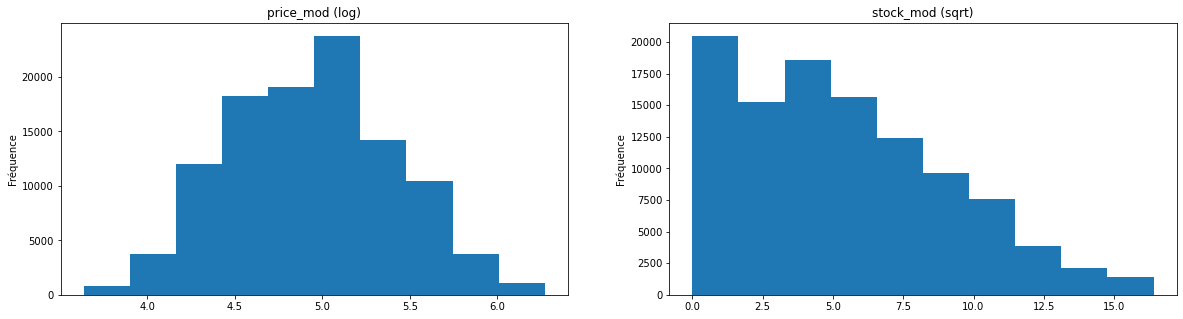

In [67]:
# transformation : 
data["price_mod"]=data["price"].map(lambda x: log(x))
data["stock_mod"]=data["stock"].map(lambda x: sqrt(x))

# on vérifie l'aspect de la nouvelle distribution : 
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(data["price_mod"])
plt.title("price_mod (log)")
plt.ylabel('Fréquence')
plt.subplot(1, 2, 2)
plt.hist(data["stock_mod"])
plt.title("stock_mod (sqrt)")
plt.ylabel('Fréquence')
plt.show()
plt.close()

Les transformations sont satisfaisantes, maintenant on supprime les anciennes colonnes de prix et de stocks, et on enregistre sous format .csv le nouveau jeu de données.

<font color='red'>
ATTENTION, dès qu'on voudra interpréter des résultats sur ces variables, se souvenir d'appliquer la transformation inverse !
</font>

In [68]:
data_mod = data.drop(["price","stock"],axis=1)
data_mod.to_csv(PATH+"requetes1_mod.csv",index=False)
var_quant = ["date","price_mod","stock_mod"]

------------------------------------------------------------------------------------------
**Remarque : investigation de coté sur les hotels qui n'ont plus de place disponibles** : 

Avec cette investigation on voit que 15% des hotels prédits n'ont plus de places disponibles. La distribution des prix des hotels pleins et non pleins est assez similaire. Celle des hotels non plein est shifté de 30-40 vers la droite (i.e. les hotels qui ont encore des places sont 30 à 40€ plus chers que les hotels qui n'ont plus de places).

proportion des hotels pleins : 15.31%


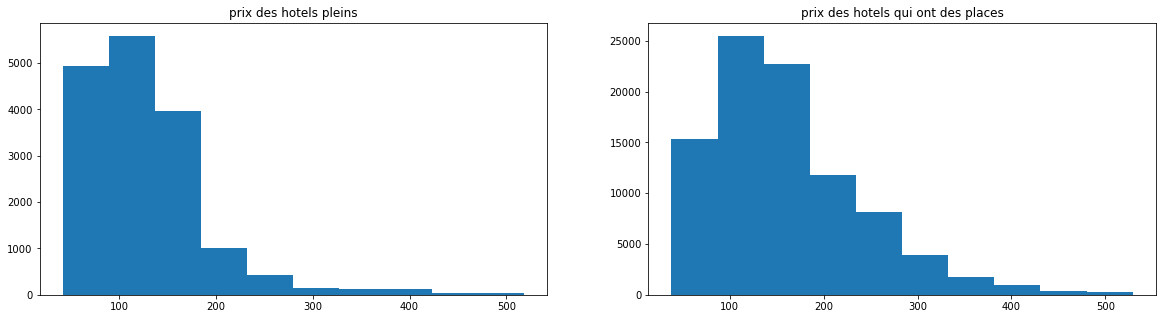

count    16388.000000
mean       127.963754
std         61.646323
min         42.000000
25%         84.000000
50%        112.000000
75%        156.000000
max        518.000000
Name: price, dtype: float64
count    90658.000000
mean       160.977035
std         78.813321
min         38.000000
25%        101.000000
50%        147.000000
75%        200.000000
max        529.000000
Name: price, dtype: float64


In [69]:
hotel_plein = np.where(data["stock"]==0)[0]
hotel_vide = np.where(data["stock"]!=0)[0]

print("proportion des hotels pleins : {:.2f}%".format(len(hotel_plein)/len(data.index)*100))

# distribution des prixs des hotels avec ou sans places disponibles :
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(data.loc[hotel_plein,'price'])
plt.title("prix des hotels pleins")
plt.subplot(1, 2, 2)
plt.hist(data.loc[hotel_vide,'price'])
plt.title("prix des hotels qui ont des places")
plt.show()
plt.close()

print(data.loc[hotel_plein,'price'].describe())
print(data.loc[hotel_vide,'price'].describe())

*fin investigation*

------------------------------------------------------------------------------------------

# Exploration multidimensionnelle

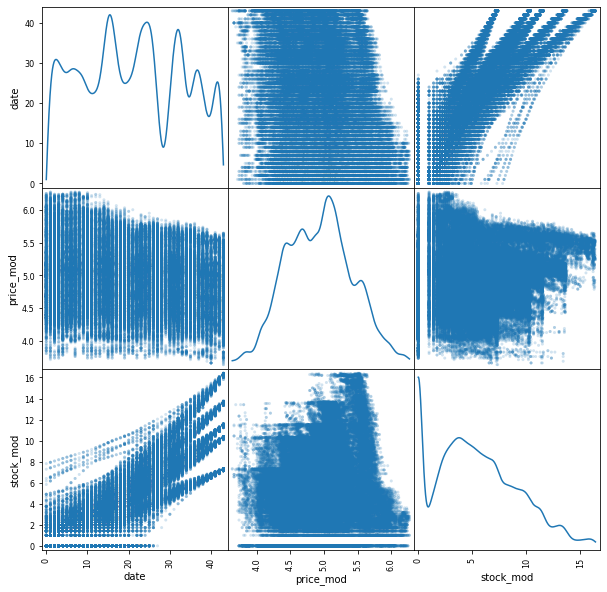

In [30]:
scatter_matrix(data_mod, alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.show()

/home/julie/anaconda3/lib/python3.8/site-packages/pyensae/graphhelper/corrplot.py:77: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if self.df.max().max() > 1 or self.df.min().min() < -1:
/home/julie/anaconda3/lib/python3.8/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


<AxesSubplot:>

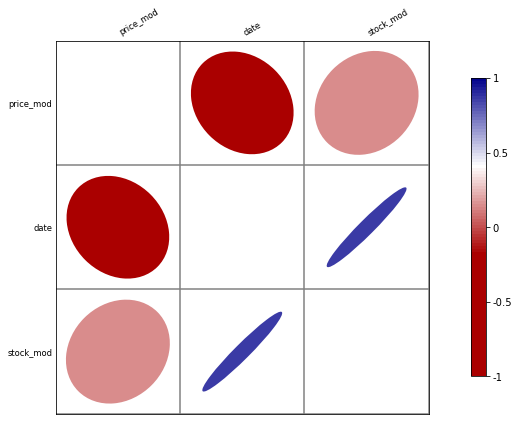

In [31]:
c = Corrplot(data_mod)
c.plot(figsize=(12,6))

Commentaire : 
- On remarque une forte corrélation positive entre le stock et la date (une relation linéaire ?). Cela signifie que les deux variables varie dans le même sens, ce qui est logique car plus la date à laquelle on veut réserver est loin, plus il y a de chances d'avoir beaucoup de places dans l'hôtel et inversement. 
- On remarque une corrélation négative entre la date et le prix, ce qui signifie que les deux variables varient dans des sens opposés. Quand la date de la requête est trèsproche de la date à laquelle on veut réserve, les prix sont plus élevés. 
- Les stocks et la date ne sont pas très corrélées. On a une faible corrélation positive donc cela signifie que quand le nombre de place diminue dans les hôtels, les prix augmentent un peu. Cela coïncide avec notre analyse sur les prix des hôtels plains/avec des places qui suggéraient que les hötels qui ont toujours des places sont 30-40€ plus chers que ceux qui osnt déjà pleins. 

# Factor-Analysis-of-Mixed-Data: FAMD

Remarque : Ici j'utilise une FAMD plutôt qu'une ACP car j'ai à la fois des variables quantitatives et qualitatives. La FAMD est une généralisationde l'ACP au cas où on a p variables quantitatives et q variables qualitatives. 

Le tuto que j'ai utilisé : https://cmdlinetips.com/2020/12/canonical-correlation-analysis-in-python/

In [79]:
# mettre toutes les données qualitatives sous le format object avant de les 
# transformer avec pd.Categorical
data_famd = pd.read_csv(PATH+'requetes1_mod.csv')
data_famd[var_quali] = data_famd[var_quali].astype('object')
for var in var_quali :
    data_famd[var]=pd.Categorical(data_famd[var],ordered=False)
data_famd.dtypes

/home/julie/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


avatar_id          category
city               category
date                  int64
language           category
mobile             category
hotel_id           category
group              category
brand              category
parking            category
pool               category
children_policy    category
price_mod           float64
stock_mod           float64
dtype: object

In [80]:
# Commencer par normaliser les données quantitatives: 
data_famd[var_quant] = scale(data_famd[var_quant])
famd = FAMD().fit(data_famd)

famd


ValueError: Not all columns in "Categorical" group are of the same type

<font color='red'>
J'ai un pb avec la FAMD sur le type dans la variable categorical je sais pas comment faire... Je verras si j'y arrive plus tard. Apparemment, c'est un bug dans la libraire qui n'a pas encore été fixé : https://github.com/pandas-dev/pandas/issues/45128
</font>

# Clustering

In [81]:
# commencer par scales les données : 
data_mod[var_quant] = scale(data_famd[var_quant])

In [82]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(data_mod)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.axhline(100, linestyle="dashed", c="gray")
plt.xlabel("Number of points in node ")
plt.show()

NameError: name 'AgglomerativeClustering' is not defined

<font color='red'>
J'ai aussi un pb avec le clustering, impossible d'importer sklearn.cluster... Vous me direz si ça marche chez vous c,0,- (tortue)
</font>